# Project Stage II - Task 1
### Francis Perez - Team 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
import scipy.stats as expon
import sys
#define the utilities folder for team functions
sys.path.insert(0,"../../util")
import teamsuperfileutilslib as tl

### Consts

In [2]:
#Plot Size
plotSize = (20,5)

## Functions

In [3]:
def get_weekly_total_from_team_df(team_confirmed_or_death_dataframe,state,county_name=None,normByPop=False,normByLog=False,roundTotal=False,popScaler=10000000.00):
    
    if (county_name is None):
        #create new dataframe by start
        data = team_confirmed_or_death_dataframe[team_confirmed_or_death_dataframe.apply(lambda x: (x["State"] == state), axis=1)].copy()
    else:
        #create new dataframe by start and by county name
        data = team_confirmed_or_death_dataframe[team_confirmed_or_death_dataframe.apply(lambda x: (x["State"] == state and x["County Name"] == county_name and \
             x["countyFIPS"] != 0), axis=1)].copy()

    #the popluation of the dataframe
    population = data["population"].sum()

    #keep only the date columns
    data = data[data.columns[5:]]

    #sum up the date columns
    data = pd.DataFrame(data[data.columns].sum(axis=0))
    
    #remove any indexes
    data.reset_index(inplace=True)
    
    #rename columns 
    data.columns=["date", "total"]

    #the the date column as a date type
    data["date"] = pd.to_datetime(data["date"])
    
    #add column with the week number
    data["week"] = data["date"].dt.week
    
    #get new cases or deaths
    data["total"] = data["total"].diff()
    

    #fill in any missing data
    data["total"] = data["total"].fillna(value=0)
    
    if normByPop:
        #normalize by population
        data["total"] = data.apply(lambda row: (row["total"] / population) * popScaler, axis=1)
    elif normByLog:
        #normalize by log
        data["total"] = data["total"].apply(lambda rowItem: 0 if rowItem == 0 else np.log(rowItem))

    if roundTotal:
        #round the total value if requested
        data["total"] = round(data["total"])

    return data

In [4]:
def get_weekly_means(team_confirmed_or_death_dataframe, state, county_name = None, normByPop = False, normByLog = False):
    #the data for the requested state and country
    data_weekly = get_weekly_total_from_team_df(team_confirmed_or_death_dataframe, state, county_name, normByPop, normByLog)
    
    #keep only needed columns
    data_weekly = data_weekly[["week", "total"]]

    #group the data by the week number and calculate the mean
    data_weekly = data_weekly.groupby("week").total.agg(["mean"])

    #round the mean for each week
    data_weekly["mean"] = round(data_weekly["mean"])
    
    #make sure the mean is an int type
    data_weekly["mean"] = data_weekly["mean"].apply(np.int64)
    return data_weekly

In [5]:
def get_mean_median_mode_tuple_from_weeks_means(weekly_means_df):
    #calculate the mean and round for all rows
    mean_val = round(weekly_means_df["mean"].mean())

    #calculate the median and round for all rows
    median_val = round(weekly_means_df["mean"].median())

    #calculate the mode rows
    mode_val = weekly_means_df["mean"].mode()

    #return the tuple of 3 with the calculated values.
    return mean_val, median_val, mode_val[0]

In [6]:
def population_by_state(team_super_file):
    #create new dataframe with the state and popluation 
    pop = team_super_file[["State","population"]].copy()

    #sum up the popluation for each state
    pop = pd.DataFrame(pop.groupby("State").population.agg(["sum"]))

    #remove any indexes
    pop.reset_index(inplace=True)

    #rename the columns
    pop.columns = ["State", "Population"]
    return pop

In [7]:
def get_county_data_totals(team_confirmed_or_death_dataframe, state, normByPop = False, normByLog = False, popScaler=10000.00):
    
    #Get counties for the requested state, only keep rows with country data.
    data_counties = team_confirmed_or_death_dataframe[team_confirmed_or_death_dataframe.apply(lambda x: (x["State"] == state and x["countyFIPS"] != 0), axis=1)].copy()

    #Remove unneeded columns
    data_counties.drop(columns=["countyFIPS", "State", "stateFIPS"], inplace=True)

    #Drop all column with dates, except for last one, as it is our totals
    data_counties.drop(columns=data_counties.columns[2:-1], inplace=True)

    #Rename last column to Total
    data_counties.rename(columns={data_counties.columns[-1]:"Total"}, inplace=True)

    if normByPop:
        #normalize by population
        data_counties["Total"] = data_counties.apply(lambda row: (row["Total"] / row["population"]) * popScaler, axis=1)
    elif normByLog:
        #normalize by log
        data_counties["Total"] = data_counties.apply(lambda row: 0 if row["Total"] == 0 else np.log(row["Total"]))

    #round the data
    data_counties["Total"] = round(data_counties["Total"])

    #Sort the data by total
    data_counties = data_counties.sort_values("Total", ascending=False)

    data_counties.reset_index(inplace=True)
    
    #Drop all column with dates, except for last one, as it is our totals
    data_counties.drop(columns=["index"], inplace=True)
    return data_counties

In [8]:
def dataframes_daily_county_data_confirmed_deaths(confirmed_usa, deaths_usa, state, county, normByPop=False, normByLog = False):

    #get the Scotland daily status for confirmed cases norm by population
    daily_data_confirmed = get_weekly_total_from_team_df(confirmed_usa,state,county,normByPop,normByLog,True,100000.00)
    #keep need columns and set the date as index
    daily_data_confirmed = daily_data_confirmed[["date", "total"]].set_index("date")

    #rename column for easy display
    daily_data_confirmed.columns = ["Confirmed"]

    #get the Scotland daily status for death norm by population
    daily_data_deaths = get_weekly_total_from_team_df(deaths_usa,state,county,normByPop,normByLog,True,100000.00)
    #keep need columns and set the date as index
    daily_data_deaths = daily_data_deaths[["date", "total"]].set_index("date")

    #rename column for easy display
    daily_data_deaths.columns= ["Deaths"]

    return (daily_data_confirmed, daily_data_deaths)

In [9]:
def plot_daily_county_data_confirmed_deaths(confirmed_usa, deaths_usa, state, county, normByPop=False, normByLog=False):

    #get data frame for each type
    data_confirmed, data_deaths = dataframes_daily_county_data_confirmed_deaths(confirmed_usa,deaths_usa,state,county,normByPop,normByLog)

    number_calc_type = ""
    if normByPop:
        number_calc_type = "Normalize By Population"
    elif normByLog:
        number_calc_type = "Log Normalize"

    #Plot the data
    data_confirmed.plot(title="{cnty} County, {st} - Confirmed Case ({nType})".format(cnty=county, st=state, nType=number_calc_type), figsize=plotSize)
    data_deaths.plot(title="{cnty} County, {st} - Deaths ({nType})".format(cnty=county, st=state, nType=number_calc_type), figsize=plotSize, color="darkred")

In [10]:
def get_recent_months_employment_dataframe(team_employmentdata,state=None,county_name=None,normByPop = False, roundTotal=False, popScaler=10000.00):
    #get all columns for the team & employment data file
    allcols = team_employmentdata.columns

    #Calcualte the columns we want to keep
    data_cols_to_use = [col for col in team_employmentdata.columns if col in allcols[0:5] or col in allcols[-6:]]

    #Create a new file with just data we want
    data = team_employmentdata[data_cols_to_use].copy()

    if (state is not None and county_name is not None):
        #create new dataframe by state and country name
        data = data[data.apply(lambda x: (x["State"] == state and x["County Name"] == county_name and x["countyFIPS"] != 0), axis=1)].copy()
    elif state is not None:
        #create enw dataframe by state only
        data = data[data.apply(lambda x: (x["State"] == state), axis=1)].copy()
       
    for col in data.columns[-6:]:
         #fill in any missing data
        data[col] = data[col].fillna(value=0)

        if normByPop:
            #normalize by population
            data[col] = data.apply(lambda row: (row[col] / row["population"]) * popScaler, axis=1)
            data[col] = round(data[col])

    return data

## Import Team Super File

In [11]:
#read team super file
team_super_df =  pd.read_csv("..\..\..\data\superCOVID-19datafame.csv")

print(team_super_df.head(1))

   countyFIPS            County Name State  population  stateFIPS  \
0           0  Statewide Unallocated    AL           0          1   

   confirmed_1/22/20  confirmed_1/23/20  confirmed_1/24/20  confirmed_1/25/20  \
0                  0                  0                  0                  0   

   confirmed_1/26/20  ...  deaths_10/9/20  deaths_10/10/20  deaths_10/11/20  \
0                  0  ...               0                0                0   

   deaths_10/12/20  deaths_10/13/20  deaths_10/14/20  deaths_10/15/20  \
0                0                0                0                0   

   deaths_10/16/20  deaths_10/17/20  deaths_10/18/20  
0                0                0                0  

[1 rows x 547 columns]


## Import Team Super File With Employment Data

In [12]:
#read team super file with Employment data
team_super_df_With_Employment = pd.read_csv("..\..\..\data\Francis\Super_Employment_Merged_Task3.csv")

print(team_super_df_With_Employment.head(1))

   countyFIPS     County Name State  population  stateFIPS  confirmed_1/22/20  \
0        1001  Autauga County    AL       55869          1                  0   

   confirmed_1/23/20  confirmed_1/24/20  confirmed_1/25/20  confirmed_1/26/20  \
0                  0                  0                  0                  0   

   ...  employment_feb_gov_state_subtotal  employment_feb_priv_goods_subtotal  \
0  ...                              586.0                              2241.0   

   employment_feb_priv_services_subtotal  employment_feb_total  \
0                                 6211.0               11047.0   

   employment_mar_gov_fed_subtotal  employment_mar_gov_local_subtotal  \
0                             85.0                             1940.0   

   employment_mar_gov_state_subtotal  employment_mar_priv_goods_subtotal  \
0                              573.0                              2224.0   

   employment_mar_priv_services_subtotal  employment_mar_total  
0            

# Task 1

## Start of Part 1. (North Carolina) - Task 1
### Generate weekly statistics (mean, median, mode) for number of cases and deaths across a specific state.

In [13]:
#Retrive the confirm cases and death cases for USA from the team super file
#Using the Team Utility function that was imported
confirmed_usa, deaths_usa = tl. get_confirmed_deaths_tuple_df_with_population(team_super_df)
print(confirmed_usa.head(5))
print(deaths_usa.head(5))

   countyFIPS            County Name State  stateFIPS  population  1/22/20  \
0           0  Statewide Unallocated    AL          1           0        0   
1        1001         Autauga County    AL          1       55869        0   
2        1003         Baldwin County    AL          1      223234        0   
3        1005         Barbour County    AL          1       24686        0   
4        1007            Bibb County    AL          1       22394        0   

   1/23/20  1/24/20  1/25/20  1/26/20  ...  10/9/20  10/10/20  10/11/20  \
0        0        0        0        0  ...        0         0         0   
1        0        0        0        0  ...     1882      1898      1905   
2        0        0        0        0  ...     6172      6190      6203   
3        0        0        0        0  ...      939       942       942   
4        0        0        0        0  ...      719       726       736   

   10/12/20  10/13/20  10/14/20  10/15/20  10/16/20  10/17/20  10/18/20  
0     

### Calcuate Totals For State (North Carolina)

In [14]:
#Calculate the weekly means for confirmed and deaths
nc_data_weekly_means_confirmed = get_weekly_means(confirmed_usa, "NC")
nc_data_weekly_means_deaths = get_weekly_means(deaths_usa, "NC")

#Calcuate the weekly statistics for NC
nc_confirmed_mean, nc_confirmed_median, nc_confirmed_mode = get_mean_median_mode_tuple_from_weeks_means(nc_data_weekly_means_confirmed)
nc_deaths_mean, nc_deaths_median, nc_deaths_mode = get_mean_median_mode_tuple_from_weeks_means(nc_data_weekly_means_deaths)

# Display The Weekly statistics For North Carolina

In [15]:
print ("North Carolina - Number of cases (Weekly)  - Mean:{mn:5} | Median:{md:5} | Mode:{mo:5}".format(mn=nc_confirmed_mean, md=nc_confirmed_median, mo=nc_confirmed_mode))
print ("North Carolina - Number of deaths (weekly) - Mean:{mn:5} | Median:{md:5} | Mode:{mo:5}".format(mn=nc_deaths_mean, md=nc_deaths_median, mo=nc_deaths_mode))

North Carolina - Number of cases (Weekly)  - Mean:  905 | Median: 1123 | Mode:    0
North Carolina - Number of deaths (weekly) - Mean:   14 | Median:   16 | Mode:    0


## End of Part 1.

## Start of Part 2.
### Compare the data against other states.

In [16]:
#Get states with simiair populations
population_by_state(team_super_df).sort_values(by='Population', ascending=False)[6:20]

,State,Population
35,OH,11689100
10,GA,10617423
27,NC,10488084
22,MI,9986857
31,NJ,8882190
47,WA,7614893
3,AZ,7278717
19,MA,6892503
42,TN,6829174
45,VA,6802317


### Calculate the statistics for these states: MI, GA, TN, WA, NJ

In [17]:
#Calculate the weekly means for confirmed (normalize by population) for MI

mi_confirmed_mean, mi_confirmed_median, mi_confirmed_mode = get_mean_median_mode_tuple_from_weeks_means(get_weekly_means(confirmed_usa, "MI", normByPop=True))
#calculate the weelky means for deaths (normalize by population) for MI
mi_deaths_mean, mi_deaths_median, mi_deaths_mode = get_mean_median_mode_tuple_from_weeks_means(get_weekly_means(deaths_usa, "MI", normByPop=True))

#Calculate the weekly means for confirmed (normalize by population) for GA
ga_confirmed_mean, ga_confirmed_median, ga_confirmed_mode = get_mean_median_mode_tuple_from_weeks_means(get_weekly_means(confirmed_usa, "GA", normByPop=True))
#calculate the weelky means for deaths (normalize by population) for GA
ga_deaths_mean, ga_deaths_median, ga_deaths_mode = get_mean_median_mode_tuple_from_weeks_means(get_weekly_means(deaths_usa, "GA", normByPop=True))

#Calculate the weekly means for confirmed (normalize by population) for TN
tn_confirmed_mean, tn_confirmed_median, tn_confirmed_mode = get_mean_median_mode_tuple_from_weeks_means(get_weekly_means(confirmed_usa, "TN", normByPop=True))
#calculate the weelky means for deaths (normalize by population) for TN
tn_deaths_mean, tn_deaths_median, tn_deaths_mode = get_mean_median_mode_tuple_from_weeks_means(get_weekly_means(deaths_usa, "TN", normByPop=True))

#Calculate the weekly means for confirmed (normalize by population) for WA
wa_confirmed_mean, wa_confirmed_median, wa_confirmed_mode = get_mean_median_mode_tuple_from_weeks_means(get_weekly_means(confirmed_usa, "WA", normByPop=True))
#calculate the weelky means for deaths (normalize by population) for WA
wa_deaths_mean, wa_deaths_median, wa_deaths_mode = get_mean_median_mode_tuple_from_weeks_means(get_weekly_means(deaths_usa, "WA", normByPop=True))

#Calculate the weekly means for confirmed (normalize by population) for NJ
nj_confirmed_mean, nj_confirmed_median, nj_confirmed_mode = get_mean_median_mode_tuple_from_weeks_means(get_weekly_means(confirmed_usa, "NJ", normByPop=True))
#calculate the weelky means for deaths (normalize by population) for NJ
nj_deaths_mean, nj_deaths_median, nj_deaths_mode = get_mean_median_mode_tuple_from_weeks_means(get_weekly_means(deaths_usa, "NJ", normByPop=True))

### Print the statistics for these states: MI, GA, TN, WA, NJ (normalize by population)

In [18]:
print("*Normalize by population")
print()

print ("Michigan   - Number of cases  (Weekly) - Mean:{mn:5} | Median:{md:5} | Mode:{mo:5}".format(mn=mi_confirmed_mean, md=mi_confirmed_median, mo=mi_confirmed_mode))
print ("Michigan   - Number of deaths (weekly) - Mean:{mn:5} | Median:{md:5} | Mode:{mo:5}".format(mn=mi_deaths_mean, md=mi_deaths_median, mo=mi_deaths_mode))
print()

print ("Georgia    - Number of cases  (Weekly) - Mean:{mn:5} | Median:{md:5} | Mode:{mo:5}".format(mn=ga_confirmed_mean, md=ga_confirmed_median, mo=ga_confirmed_mode))
print ("Georgia    - Number of deaths (weekly) - Mean:{mn:5} | Median:{md:5} | Mode:{mo:5}".format(mn=ga_deaths_mean, md=ga_deaths_median, mo=ga_deaths_mode))
print()

print ("Tennessee  - Number of cases  (Weekly) - Mean:{mn:5} | Median:{md:5} | Mode:{mo:5}".format(mn=tn_confirmed_mean, md=tn_confirmed_median, mo=tn_confirmed_mode))
print ("Tennessee  - Number of deaths (weekly) - Mean:{mn:5} | Median:{md:5} | Mode:{mo:5}".format(mn=tn_deaths_mean, md=tn_deaths_median, mo=tn_deaths_mode))
print()

print ("Washington - Number of cases  (Weekly) - Mean:{mn:5} | Median:{md:5} | Mode:{mo:5}".format(mn=wa_confirmed_mean, md=wa_confirmed_median, mo=wa_confirmed_mode))
print ("Washington - Number of deaths (weekly) - Mean:{mn:5} | Median:{md:5} | Mode:{mo:5}".format(mn=wa_deaths_mean, md=wa_deaths_median, mo=wa_deaths_mode))
print()

print ("New Jersey - Number of cases  (Weekly) - Mean:{mn:5} | Median:{md:5} | Mode:{mo:5}".format(mn=nj_confirmed_mean, md=nj_confirmed_median, mo=nj_confirmed_mode))
print ("New Jersey - Number of deaths (weekly) - Mean:{mn:5} | Median:{md:5} | Mode:{mo:5}".format(mn=nj_deaths_mean, md=nj_deaths_median, mo=nj_deaths_mode))

*Normalize by population

Michigan   - Number of cases  (Weekly) - Mean:  591 | Median:  651 | Mode:    0
Michigan   - Number of deaths (weekly) - Mean:   27 | Median:   11 | Mode:    0

Georgia    - Number of cases  (Weekly) - Mean: 1175 | Median:  786 | Mode:    0
Georgia    - Number of deaths (weekly) - Mean:   26 | Median:   29 | Mode:    0

Tennessee  - Number of cases  (Weekly) - Mean: 1227 | Median:  735 | Mode:    0
Tennessee  - Number of deaths (weekly) - Mean:   16 | Median:   11 | Mode:    0

Washington - Number of cases  (Weekly) - Mean:  472 | Median:  486 | Mode:    0
Washington - Number of deaths (weekly) - Mean:   11 | Median:   10 | Mode:    0

New Jersey - Number of cases  (Weekly) - Mean:  906 | Median:  431 | Mode:    0
New Jersey - Number of deaths (weekly) - Mean:   67 | Median:    9 | Mode:    0


## End Part 2.

## Start of Part 3.
### Identify counties with high cases and death rates for North Carolina.

### Calucate data for the top infected countries

In [19]:
#Get list of counties in north carolina sorted by total confirmed (normalize by population)
nc_data_counties_confirmed = get_county_data_totals(confirmed_usa, "NC", normByPop=True, popScaler=100000.00)
nc_data_counties_confirmed.rename(columns={"Total":"Confirmed"}, inplace=True)

nc_data_counties_deaths = get_county_data_totals(deaths_usa, "NC", normByPop=True, popScaler=100000.00)
nc_data_counties_deaths.drop(columns=["population"], inplace=True)
nc_data_counties_deaths.rename(columns={"Total":"Deaths"}, inplace=True)

nc_data_counties_merged = pd.merge(left=nc_data_counties_confirmed, right=nc_data_counties_deaths, left_on="County Name", right_on="County Name" , how="inner")

### Show Top 5 Counties with highest confirmed cases.

In [20]:
#Print top 5 counties with larest confirmed cases
print("**Counties With The Largest Number of Cases, normalize by population**")
print()
print(nc_data_counties_merged.sort_values(by='Confirmed', ascending=False).head(5))

**Counties With The Largest Number of Cases, normalize by population**

         County Name  population  Confirmed  Deaths
0      Duplin County       58741     4549.0    92.0
1    Scotland County       34823     4414.0    63.0
2     Robeson County      130625     4301.0    66.0
3  Montgomery County       27173     4203.0   140.0
4     Sampson County       63531     4007.0    44.0


### Show Top 5 Counties with Largest Deaths.

In [21]:
#Print top 5 counties with larest confirmed cases
print("**Counties With The Largest Number of Deaths, normalize by population**")
print()
print(nc_data_counties_merged.sort_values(by='Deaths', ascending=False).head(5))

**Counties With The Largest Number of Deaths, normalize by population**

          County Name  population  Confirmed  Deaths
77       Jones County        9419     1837.0   159.0
8     Hertford County       23677     3569.0   144.0
3   Montgomery County       27173     4203.0   140.0
26    Columbus County       55508     2836.0   106.0
38       Vance County       44535     2576.0   103.0


## Top - 5 Infected Counties In North Carolina
- Duplin County
- Hertford County
- Jones County 
- Robeson County
- Scotland County

*These counties were chosen From the previous part of highest cases and deaths listing, round robin from each list until 5 total. (normalize by population)

## End of Part 3

## Start of Part 4.
### Plot daily trends (cases and deaths, new cases) of state and top 5 infected counties. Utilize aggregrate, normalized by population, and log normalized values.

### Plot Daily Trends For State - North Carolina (normalize by population)

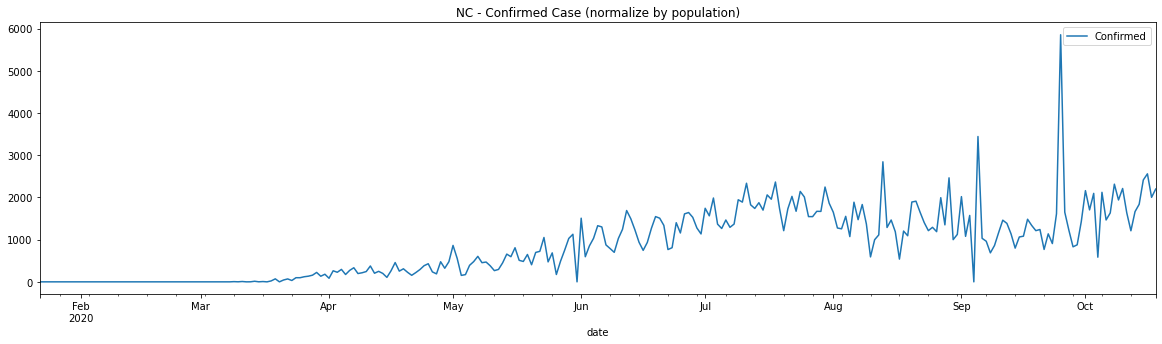

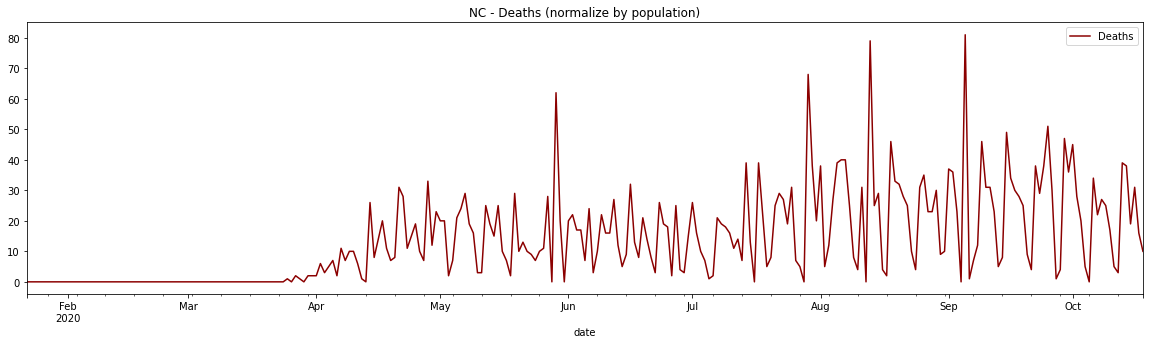

In [22]:
#get the nc daily status for confirmed cases norm by population
NC_confirmed_pop = get_weekly_total_from_team_df(confirmed_usa,"NC",normByPop=True, roundTotal=True)[["date", "total"]].set_index("date")
#rename column for easy display
NC_confirmed_pop.columns = ["Confirmed"]

#get the nc daily status for deaths norm by populaion
NC_deaths_pop = get_weekly_total_from_team_df(deaths_usa,"NC",normByPop=True, roundTotal=True)[["date", "total"]].set_index("date")
#rename column for easy display
NC_deaths_pop.columns = ["Deaths"]

#Plot the data
NC_confirmed_pop.plot(title="NC - Confirmed Case (normalize by population)", figsize=plotSize)
NC_deaths_pop.plot(title="NC - Deaths (normalize by population)", figsize=plotSize, color="darkred" )

### Plot Daily Trends For State - North Carolina (log normalize)

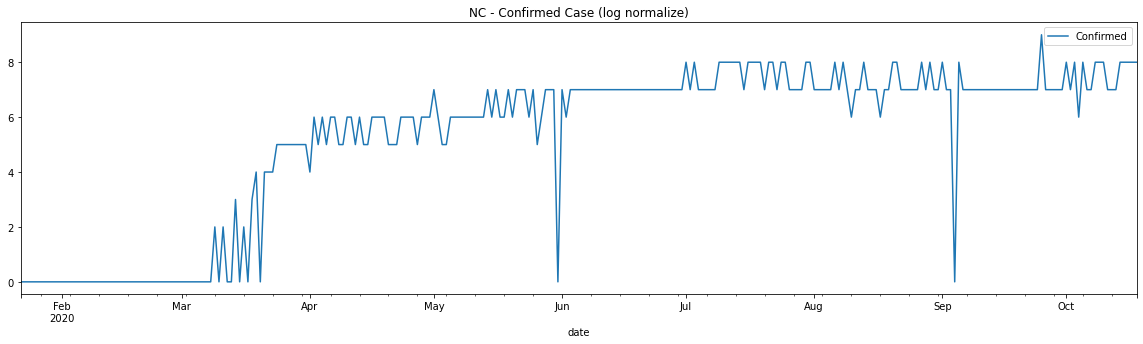

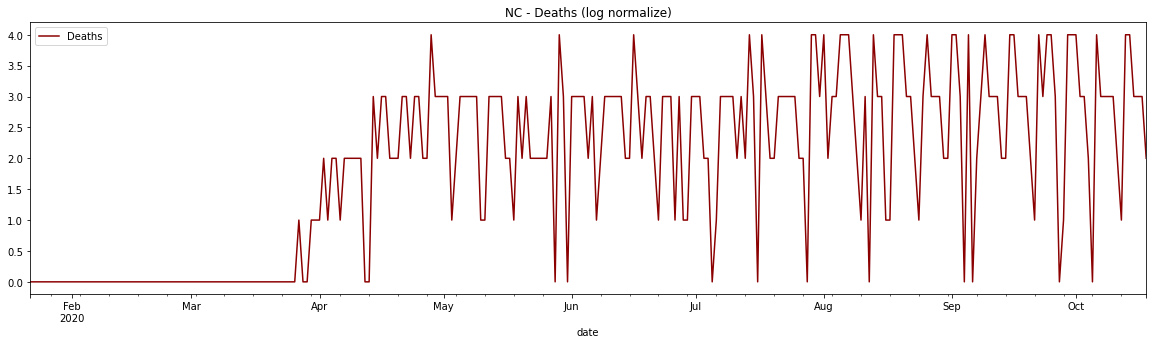

In [23]:
#get the nc daily status for confirmed cases log norm
NC_confirmed_pop = get_weekly_total_from_team_df(confirmed_usa,"NC",normByLog=True, roundTotal=True)[["date", "total"]].set_index("date")
#rename column for easy display
NC_confirmed_pop.columns = ["Confirmed"]

#get the nc daily status for deaths log norm
NC_deaths_pop = get_weekly_total_from_team_df(deaths_usa,"NC",normByLog=True, roundTotal=True)[["date", "total"]].set_index("date")
#rename column for easy display
NC_deaths_pop.columns = ["Deaths"]

#Plot the data
NC_confirmed_pop.plot(title="NC - Confirmed Case (log normalize)", figsize=plotSize)
NC_deaths_pop.plot(title="NC - Deaths (log normalize)", figsize=plotSize, color="darkred" )

## Ploting Daily Trends For Top - 5 Infected Countries In North Carolina
- Duplin County
- Hertford County
- Jones County 
- Robeson County
- Scotland County

*These counties were chosen From the previous part of hightest cases and deaths listing, round robin from each list until 5 total. (normalize by population)

### Plot Data For Duplin County

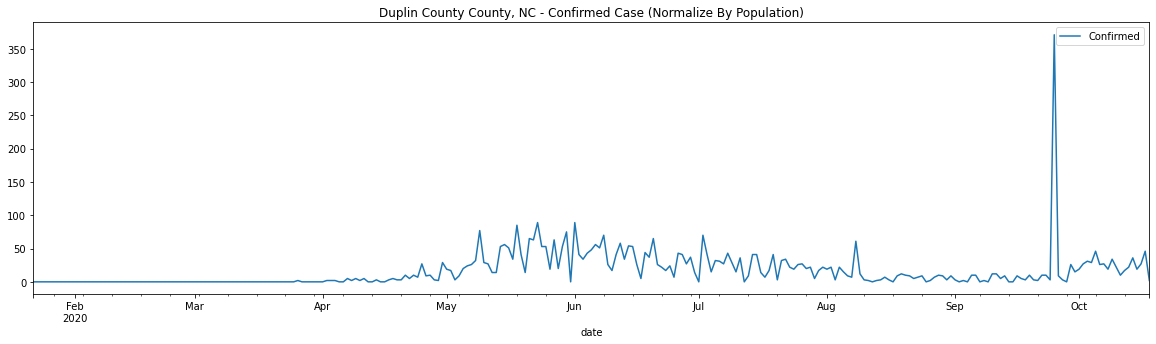

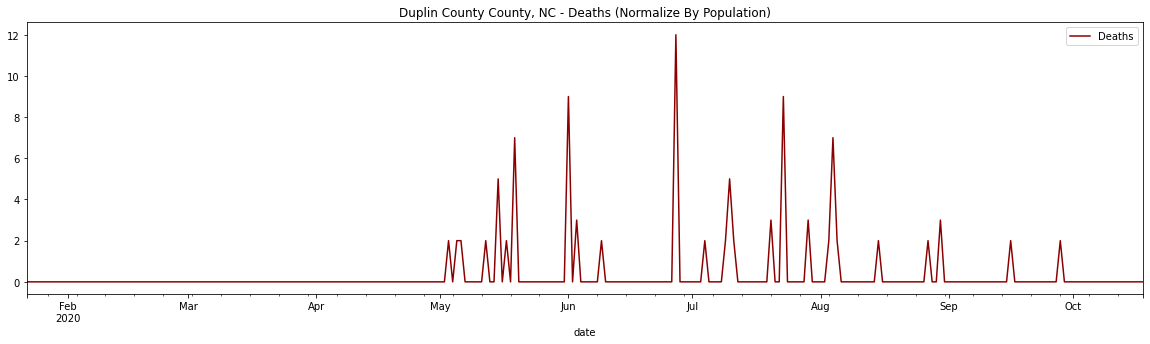

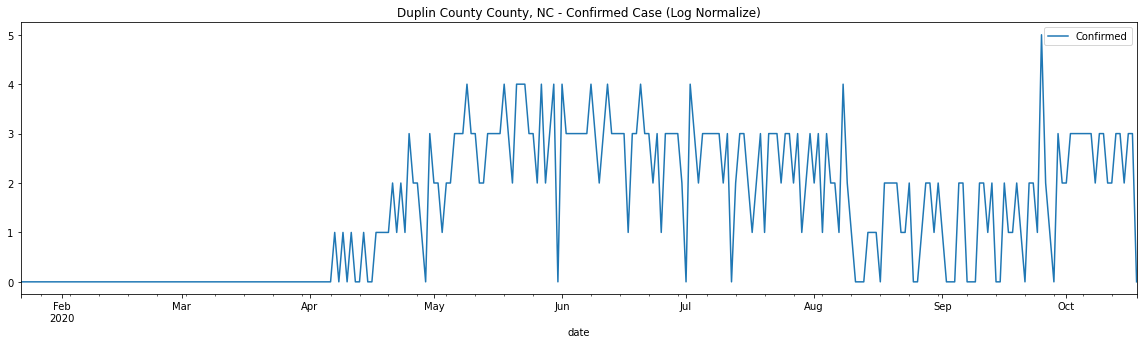

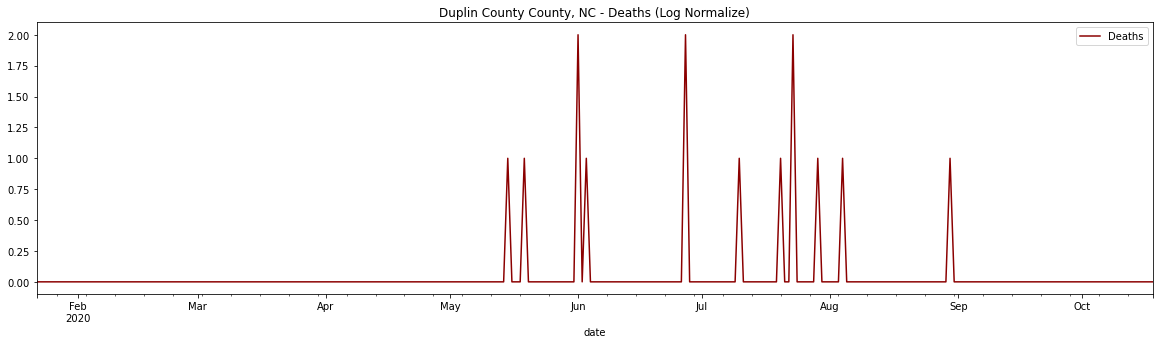

In [24]:
#Plot data for Duplin County - Normalize by Population
plot_daily_county_data_confirmed_deaths(confirmed_usa, deaths_usa,"NC","Duplin County",normByPop=True)

#Plot data for Duplin County - Log Normalize
plot_daily_county_data_confirmed_deaths(confirmed_usa, deaths_usa,"NC","Duplin County",normByLog=True)

### Plot Data For Hertford County

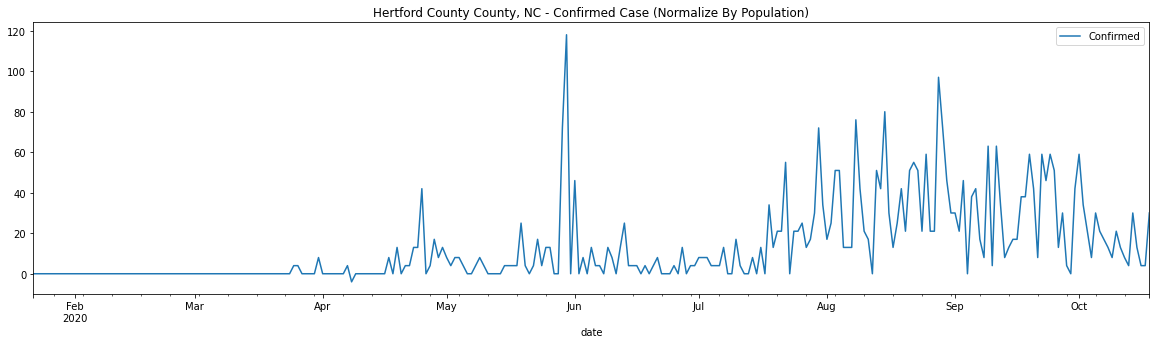

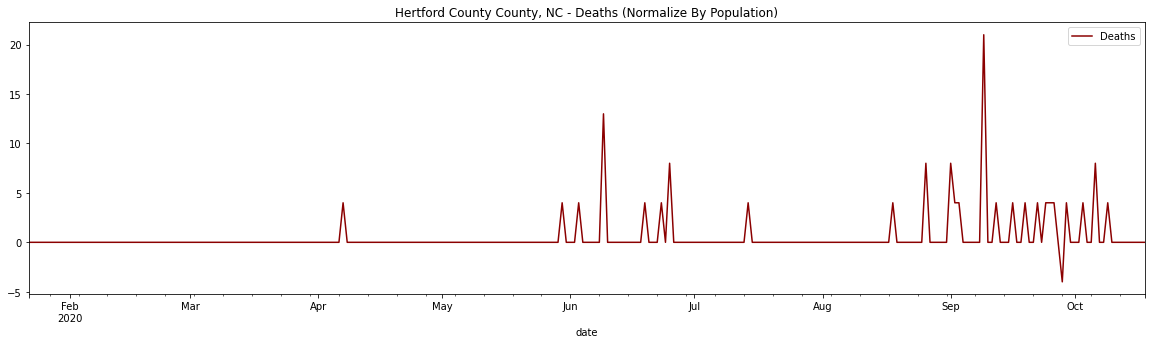

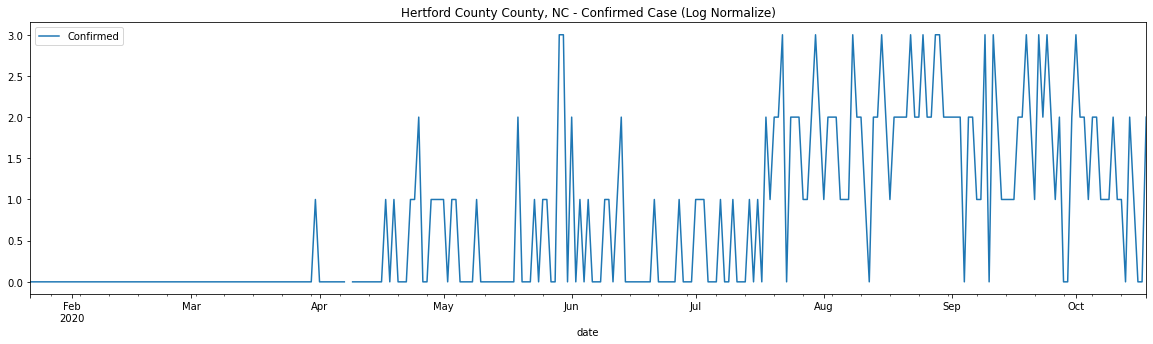

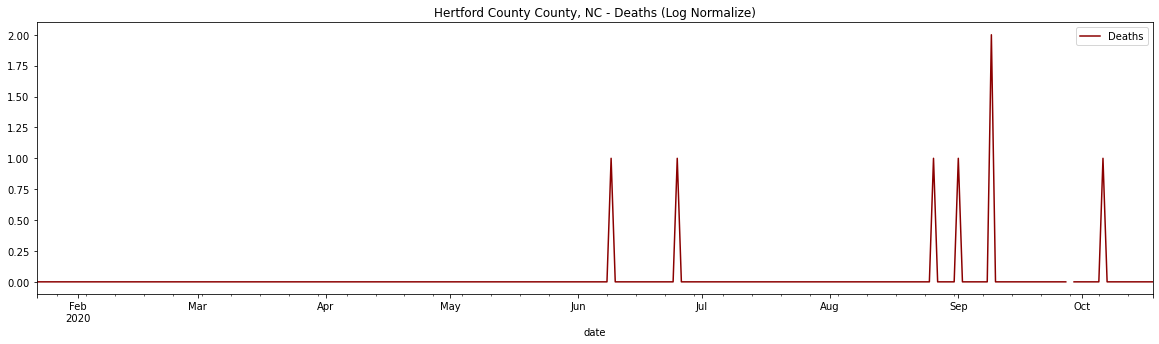

In [25]:
#Plot data for Hertford County - Normalize by Population
plot_daily_county_data_confirmed_deaths(confirmed_usa, deaths_usa,"NC","Hertford County",normByPop=True)

#Plot data for Hertford County - Log Normalize
plot_daily_county_data_confirmed_deaths(confirmed_usa, deaths_usa,"NC","Hertford County",normByLog=True)

### Plot Data For Jones County

In [26]:
#Plot data for Jones County - Normalize by Population
plot_daily_county_data_confirmed_deaths(confirmed_usa, deaths_usa,"NC","Jones County",normByPop=True)

#Plot data for Jones County - Log Normalize
plot_daily_county_data_confirmed_deaths(confirmed_usa, deaths_usa,"NC","Jones County",normByLog=True)

### Plot Data For Robeson County

In [1]:
#Plot data for Robeson County - Normalize by Population
plot_daily_county_data_confirmed_deaths(confirmed_usa, deaths_usa,"NC","Robeson County",normByPop=True)

#Plot data for Robeson County - Log Normalize
plot_daily_county_data_confirmed_deaths(confirmed_usa, deaths_usa,"NC","Robeson County",normByLog=True)

NameError: name 'plot_daily_county_data_confirmed_deaths' is not defined

### Plot Data For Scotland County

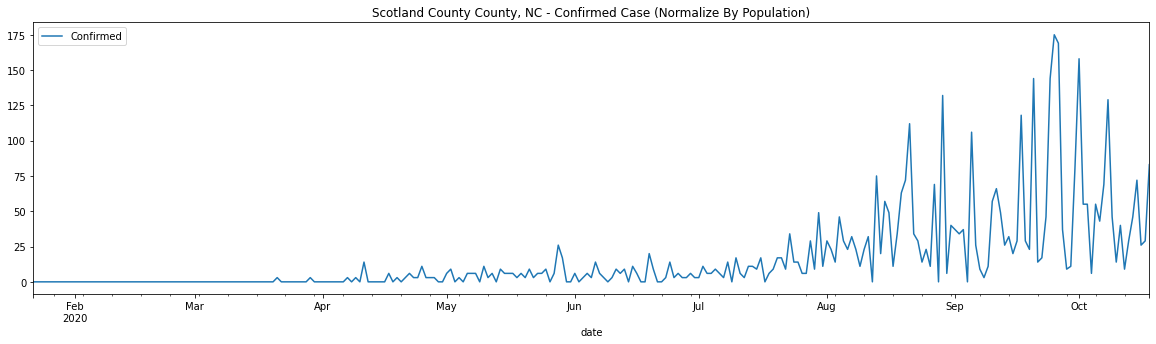

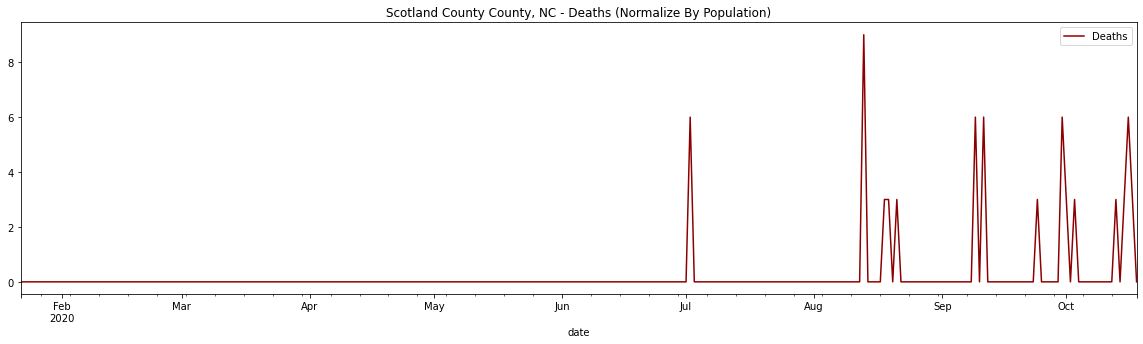

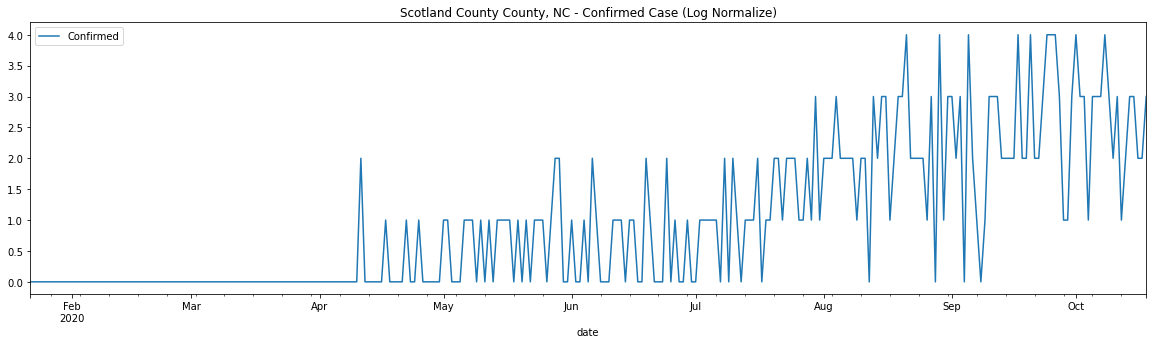

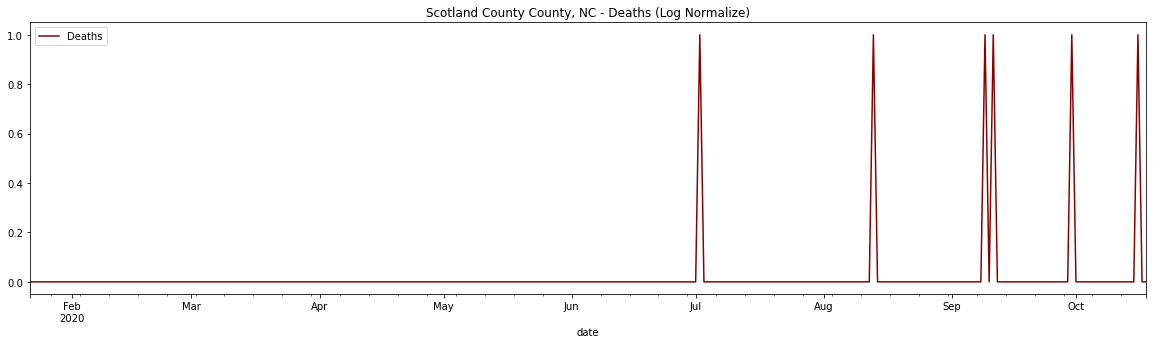

In [29]:
#Plot data for Scotland County - Normalize by Population
plot_daily_county_data_confirmed_deaths(confirmed_usa, deaths_usa,"NC","Scotland County",normByPop=True)

#Plot data for Scotland County - Log Normalize
plot_daily_county_data_confirmed_deaths(confirmed_usa, deaths_usa,"NC","Scotland County",normByLog=True)

### Plot Top-5 Counties Together - Confirmed Cases & Deaths - Normalize by Population

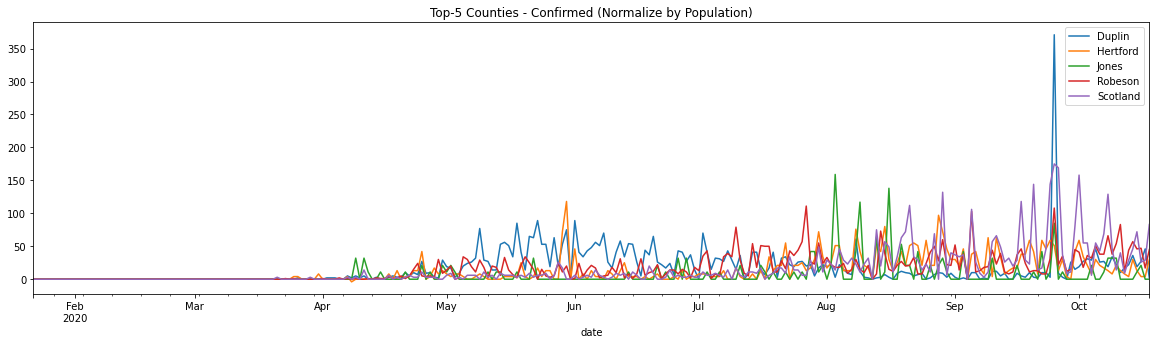

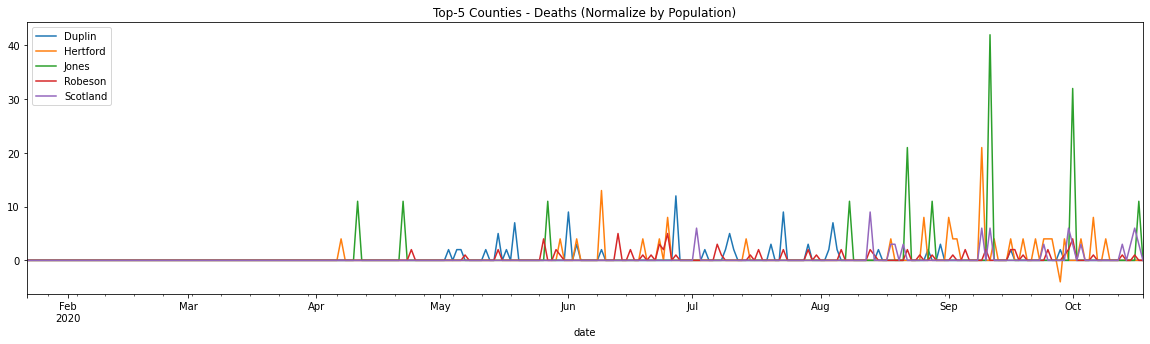

In [138]:
#Compute the Confirmed Cases & Deaths for each of the selected counties in NC
dup_cf, dup_df = dataframes_daily_county_data_confirmed_deaths(confirmed_usa, deaths_usa,"NC","Duplin County",normByPop=True)
htf_cf, htf_df = dataframes_daily_county_data_confirmed_deaths(confirmed_usa, deaths_usa,"NC","Hertford County",normByPop=True)
jn_cf, jn_df = dataframes_daily_county_data_confirmed_deaths(confirmed_usa, deaths_usa,"NC","Jones County",normByPop=True)
rc_cf, rc_df = dataframes_daily_county_data_confirmed_deaths(confirmed_usa, deaths_usa,"NC","Robeson County",normByPop=True)
sc_cf, sc_df = dataframes_daily_county_data_confirmed_deaths(confirmed_usa, deaths_usa,"NC","Scotland County",normByPop=True)

#Change the column name to match their county
dup_cf.columns = ["Duplin"]
dup_df.columns = ["Duplin"]

htf_cf.columns = ["Hertford"]
htf_df.columns = ["Hertford"]

jn_cf.columns = ["Jones"]
jn_df.columns = ["Jones"]

rc_cf.columns = ["Robeson"]
rc_df.columns = ["Robeson"]

sc_cf.columns = ["Scotland"]
sc_df.columns = ["Scotland"]

#Merge all the counties together for the confirmed cases
all_counties_merged_confirmed = pd.merge(pd.merge(pd.merge(pd.merge(dup_cf,htf_cf,left_on="date",right_on="date"),jn_cf, left_on="date", right_on="date"), rc_cf, left_on="date", right_on="date"), sc_cf, left_on="date", right_on="date")
all_counties_merged_confirmed.plot(title="Top-5 Counties - Confirmed (Normalize by Population)",figsize=plotSize)

#Merge all the counties together for the deaths
all_counties_merged_deaths = pd.merge(pd.merge(pd.merge(pd.merge(dup_df,htf_df,left_on="date",right_on="date"),jn_df, left_on="date", right_on="date"), rc_df, left_on="date", right_on="date"), sc_df, left_on="date", right_on="date")
all_counties_merged_deaths.plot(title="Top-5 Counties - Deaths (Normalize by Population)",figsize=plotSize)

### Plot Top-5 Counties Together - Confirmed Cases & Deaths - Log Normalize

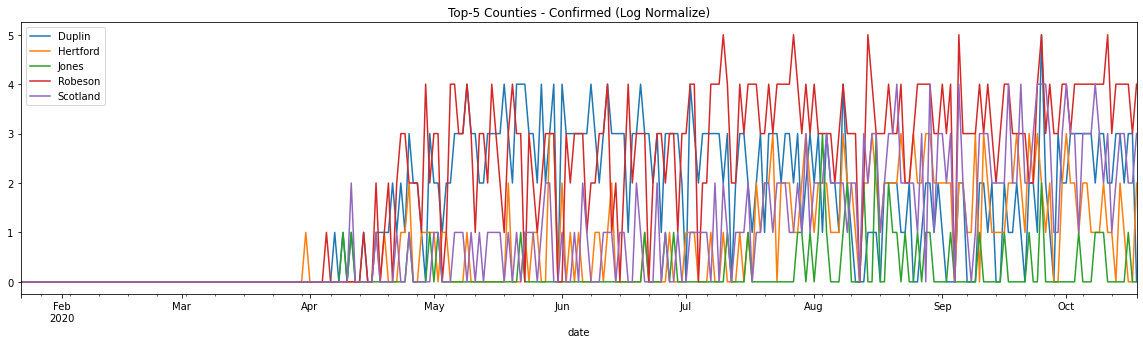

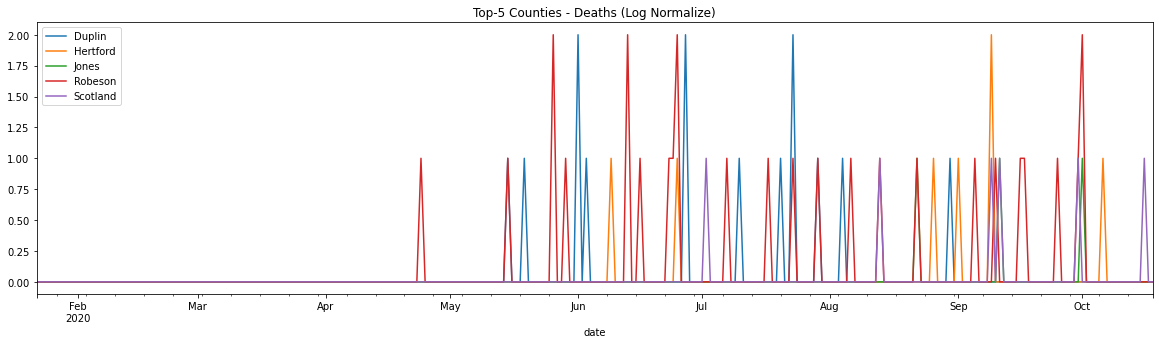

In [31]:
#Compute the Confirmed Cases & Deaths for each of the selected counties in NC
dup_cf_log, dup_df_log = dataframes_daily_county_data_confirmed_deaths(confirmed_usa, deaths_usa,"NC","Duplin County",normByLog=True)
htf_cf_log, htf_df_log = dataframes_daily_county_data_confirmed_deaths(confirmed_usa, deaths_usa,"NC","Hertford County",normByLog=True)
jn_cf_log, jn_df_log = dataframes_daily_county_data_confirmed_deaths(confirmed_usa, deaths_usa,"NC","Jones County",normByLog=True)
rc_cf_log, rc_df_log = dataframes_daily_county_data_confirmed_deaths(confirmed_usa, deaths_usa,"NC","Robeson County",normByLog=True)
sc_cf_log, sc_df_log = dataframes_daily_county_data_confirmed_deaths(confirmed_usa, deaths_usa,"NC","Scotland County",normByLog=True)

#Change the column name to match their county
dup_cf_log.columns = ["Duplin"]
dup_df_log.columns = ["Duplin"]

htf_cf_log.columns = ["Hertford"]
htf_df_log.columns = ["Hertford"]

jn_cf_log.columns = ["Jones"]
jn_df_log.columns = ["Jones"]

rc_cf_log.columns = ["Robeson"]
rc_df_log.columns = ["Robeson"]

sc_cf_log.columns = ["Scotland"]
sc_df_log.columns = ["Scotland"]

#Merge all the counties together for the confirmed cases
all_counties_merged_confirmed = pd.merge(pd.merge(pd.merge(pd.merge(dup_cf_log,htf_cf_log,left_on="date",right_on="date"),jn_cf_log, left_on="date", right_on="date"), rc_cf_log, left_on="date", right_on="date"), sc_cf_log, left_on="date", right_on="date")
all_counties_merged_confirmed.plot(title="Top-5 Counties - Confirmed (Log Normalize)",figsize=plotSize)

#Merge all the counties together for the deaths
all_counties_merged_deaths = pd.merge(pd.merge(pd.merge(pd.merge(dup_df_log,htf_df_log,left_on="date",right_on="date"),jn_df_log, left_on="date", right_on="date"), rc_df_log, left_on="date", right_on="date"), sc_df_log, left_on="date", right_on="date")
all_counties_merged_deaths.plot(title="Top-5 Counties - Deaths (Log Normalize)",figsize=plotSize)

## End of Part 4